# Project: Used Car Market Value Prediction

The used car sales service **Rusty Bargain** is developing an app to attract new customers. With this app, users can quickly find out the market value of their cars. You have access to historical data, including technical specifications, trim versions, and pricing.

The goal of this project is to build a machine learning model to determine the market value of vehicles.

### Business Requirements
Rusty Bargain is specifically interested in:
* **Prediction Quality:** Minimizing the error (RMSE).
* **Prediction Speed:** How fast the model can provide a price.
* **Training Time:** The time required to tune and fit the model.

## Abstract

This project aims to predict the **price of used cars** based on historical data and vehicle characteristics using **Supervised Machine Learning** techniques. After performing data cleaning and building a robust preprocessing pipeline, several models were evaluated — including **Linear Regression**, **Ridge**, **Decision Tree**, and **Random Forest**.

The results indicated that tree-based models achieved the best performance. Specifically, the **Random Forest** model stood out with an **RMSE ≈ 1920.80**, successfully balancing precision and generalization capability. Consequently, the final model proved to be efficient for practical application, serving as a solid foundation for future optimizations and production deployment.

## Preparação de Dados

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

sns.set(style="whitegrid", palette="pastel", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)


In [97]:
df = pd.read_csv('../data/car_data.csv')
df.info()
df.head()

<class 'pandas.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   DateCrawled        354369 non-null  str  
 1   Price              354369 non-null  int64
 2   VehicleType        316879 non-null  str  
 3   RegistrationYear   354369 non-null  int64
 4   Gearbox            334536 non-null  str  
 5   Power              354369 non-null  int64
 6   Model              334664 non-null  str  
 7   Mileage            354369 non-null  int64
 8   RegistrationMonth  354369 non-null  int64
 9   FuelType           321474 non-null  str  
 10  Brand              354369 non-null  str  
 11  NotRepaired        283215 non-null  str  
 12  DateCreated        354369 non-null  str  
 13  NumberOfPictures   354369 non-null  int64
 14  PostalCode         354369 non-null  int64
 15  LastSeen           354369 non-null  str  
dtypes: int64(7), str(9)
memory usage: 43.3 MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [98]:
# Remover duplicatas
df = df.drop_duplicates().reset_index(drop=True)

In [99]:
# Tratar valores ausentes nas categóricas
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
df[cat_cols] = df[cat_cols].fillna('unknown')


In [100]:
# Remover colunas desnecessárias
df = df.drop(columns=['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen'], errors='ignore')
df.columns.tolist()

['Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Mileage',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'NotRepaired',
 'PostalCode']

In [101]:
# Corrigir outliers
current_year = datetime.datetime.now().year
df = df[(df['RegistrationYear'] >= 1900) & (df['RegistrationYear'] <= current_year)]
df = df[(df['Power'] > 10) & (df['Power'] <= 1000)]
df = df[(df['Price'] > 0)]

In [102]:
# Criar feature 'CarAge'
df['CarAge'] = current_year - df['RegistrationYear']

In [103]:
# Verificar 'unknown' e avaliar se devemos manter ou nāo
for col in cat_cols:
    print(f"{col}: {(df[col] == 'unknown').mean():.2%} de registros 'unknown'")

VehicleType: 6.95% de registros 'unknown'
Gearbox: 1.98% de registros 'unknown'
Model: 4.01% de registros 'unknown'
FuelType: 6.44% de registros 'unknown'
Brand: 0.00% de registros 'unknown'
NotRepaired: 15.34% de registros 'unknown'


### Analysis of "Unknown" Values

| Column        | % "Unknown" | Evaluation      | Recommended Action                             |
| ------------- | ----------- | --------------- | ---------------------------------------------- |
| `VehicleType` | 6.95%       | **Low** | ✅ Keep as category                            |
| `Gearbox`     | 1.98%       | **Very Low** | ✅ Keep                                        |
| `Model`       | 4.01%       | **Low** | ✅ Keep (no significant impact)                |
| `FuelType`    | 6.44%       | **Low** | ✅ Keep                                        |
| `NotRepaired` | 15.34%      | **Moderate** ⚠️ | ✅ Keep, but monitor impact on price behavior  |

### NotRepaired (15.34%)

In this column, the percentage is **higher**, but still **acceptable**.

There is an important reason for **keeping** these values:

> The fact that a seller **does not disclose** whether the car was repaired may carry **actual significance**—  
> often, the car is **damaged**, and the owner **avoids answering**.

💡 This can serve as an **indirect signal of lower value**,  
and the **model can learn this relationship** during training!

In [104]:
# Agrupar modelos raros
top_models = df['Model'].value_counts().nlargest(20).index
df['Model'] = df['Model'].apply(lambda x: x if x in top_models else 'other')

In [105]:
print("Dataset final:", df.shape)
print()

# ===============================
# Alterações de tipos
# ===============================

# Converter Price para float (mas consistente para métricas)
df['Price'] = df['Price'].astype(float)

# Converter colunas categóricas para 'category'
# Para reduzir memória e permite que LightGBM e CatBoost reconheçam automaticamente
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
df[cat_cols] = df[cat_cols].astype('category')

# Converter PostalCode para category
# É um código de região, não valor numérico real
df['PostalCode'] = df['PostalCode'].astype('category')

# Converter RegistrationMonth para category
# Captura sazonalidade, importante para árvores
df['RegistrationMonth'] = df['RegistrationMonth'].astype('category')

# Demais colunas numéricas (Power, Mileage, CarAge) mantêm int64
# df['Power'], df['Mileage'], df['CarAge'] já estão corretos

df.info()
print()
df.head()

Dataset final: (306444, 13)

<class 'pandas.DataFrame'>
Index: 306444 entries, 1 to 354106
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              306444 non-null  float64 
 1   VehicleType        306444 non-null  category
 2   RegistrationYear   306444 non-null  int64   
 3   Gearbox            306444 non-null  category
 4   Power              306444 non-null  int64   
 5   Model              306444 non-null  category
 6   Mileage            306444 non-null  int64   
 7   RegistrationMonth  306444 non-null  category
 8   FuelType           306444 non-null  category
 9   Brand              306444 non-null  category
 10  NotRepaired        306444 non-null  category
 11  PostalCode         306444 non-null  category
 12  CarAge             306444 non-null  int64   
dtypes: category(8), float64(1), int64(4)
memory usage: 16.7 MB



,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,CarAge
1,18300.0,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,66954,15
2,9800.0,suv,2004,auto,163,other,125000,8,gasoline,jeep,unknown,90480,22
3,1500.0,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,25
4,3600.0,small,2008,manual,69,other,90000,7,gasoline,skoda,no,60437,18
5,650.0,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775,31


## Summary — Data Preparation

### Objective
Before training any model, it is essential to **prepare and clean the data** to ensure that the machine learning algorithm functions correctly and produces reliable predictions.

---

### Steps Taken

1. **Loading and Initial Inspection**
   - Read the dataset `car_data.csv`.
   - Used `info()` and `head()` to understand data types and completeness.

2. **Removal of Unnecessary Columns**
   - Excluded columns that do not contribute to the model and are purely informative:
     - `DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`.

3. **Outlier Correction**
   - Adjusted anomalous values in columns such as `Power` and `RegistrationYear` that could distort the training process.

4. **Handling Missing Values**
   - Replaced null values (`NaN`) in categorical columns with `'unknown'`.
   - Kept `'unknown'` in **NotRepaired**, as the absence of a response may indicate something relevant (e.g., damaged car).

5. **Grouping Rare Models**
   - Unified infrequent models (those outside the top 20) into the `'other'` category to reduce noise and simplify learning.

6. **Creation of the `CarAge` Feature**
   - Calculated the car's age based on the registration year:
     ```
     CarAge = 2025 - RegistrationYear
     ```

7. **Data Type Adjustments**
   - Converted `Price` to `float`.
   - Converted categorical columns to the `category` type:
     `['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode', 'RegistrationMonth']`.
   - Kept numerical columns as `int` (`Power`, `Mileage`, `CarAge`).

---

### 📊 Final Result
After preprocessing, we obtained a clean and optimized dataset:

- **Final Size:** `(306,444 rows, 13 columns)`
- **Ready for:** Split into training and validation sets.

---

### Conclusion
The data is now standardized, with categorical variables handled, missing values resolved, and types optimized. With this solid foundation, we can proceed to **Model Training**.

## 🧭 Exploratory Data Analysis (EDA)

Before starting the data preparation, it is essential to understand the behavior and relationships between variables. 
Exploratory Data Analysis (EDA) allows us to identify **patterns**, **trends**, **anomalies**, and **key relationships** that influence vehicle prices.

In this stage, the following primary aspects of the dataset were analyzed:

* **Vehicle price distribution**, to understand value ranges and the presence of outliers.
* **Relationship between price and fuel type**, to verify how different energy sources impact value.
* **Relationship between price and vehicle type**, highlighting categories with higher or lower market values.
* **Correlation between numerical variables**, to identify potential dependencies between attributes such as power, mileage, and age.

These analyses help guide decisions in the **data preparation** and **predictive modeling** stages, ensuring a better understanding of the context before training the models.

💡 *The following sections present the main charts and interpretations that comprise this exploratory analysis stage.*

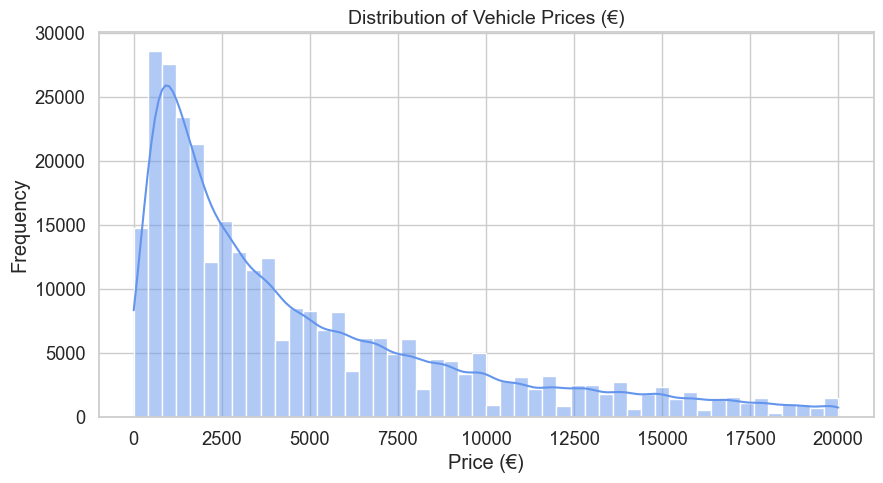

In [121]:
# Price Distribution

plt.figure(figsize=(10,5))
sns.histplot(df['Price'], bins=50, kde=True, color='cornflowerblue')

plt.title("Distribution of Vehicle Prices (€)", fontsize=14)
plt.xlabel("Price (€)")
plt.ylabel("Frequency")
plt.show()

## Interpretation:
* The majority of vehicles are concentrated in lower price ranges (up to approximately €10,000), with a long tail indicating the presence of high-value cars.

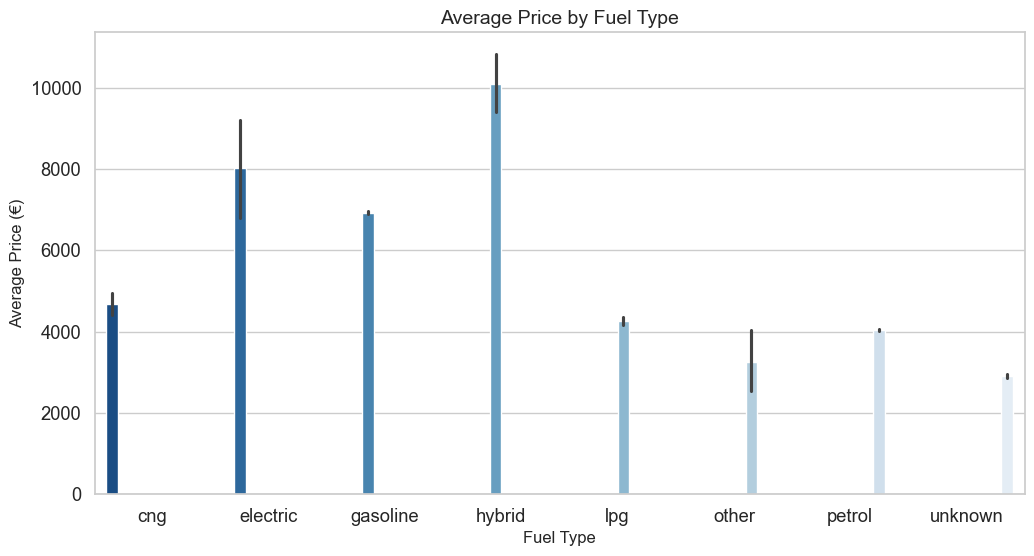

In [120]:
# Average Price by Fuel Type

plt.figure(figsize=(12,6))
# Using 'hue' to avoid warnings in newer Seaborn versions
sns.barplot(
    data=df, 
    x='FuelType', 
    y='Price', 
    estimator=np.mean, 
    palette='Blues_r', 
    hue='FuelType', 
    legend=False
)

plt.title("Average Price by Fuel Type", fontsize=14)
plt.xlabel("Fuel Type", fontsize=12)
plt.ylabel("Average Price (€)", fontsize=12)
plt.show()

## Interpretation:
* Vehicles powered by alternative energy (such as hybrids or electric cars) tend to have higher average prices, whereas gasoline and diesel cars show wide variation, reflecting different market segments.

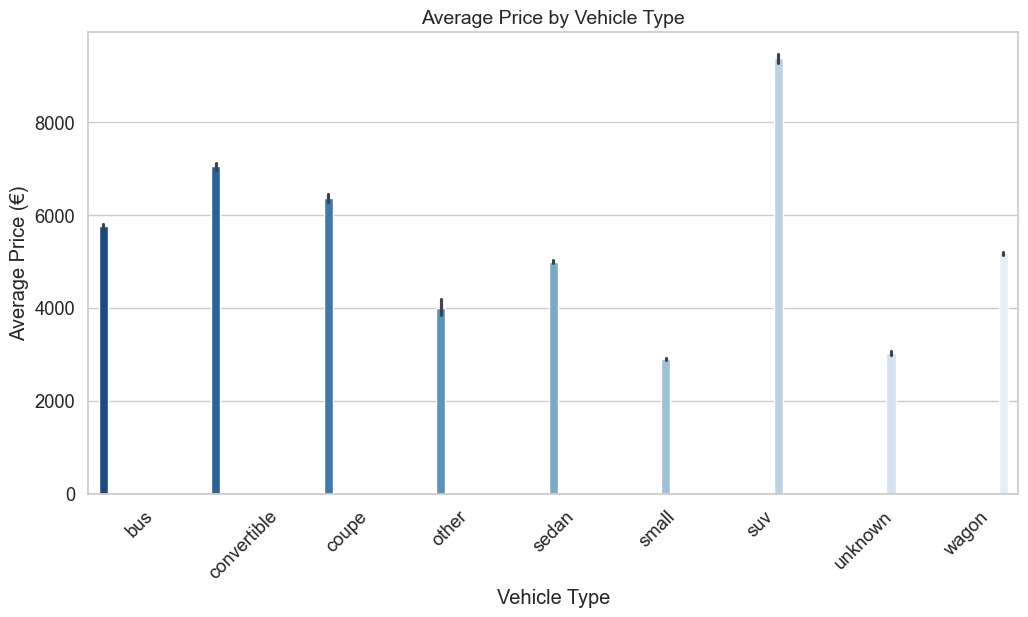

In [119]:
# Average Price by Vehicle Type

plt.figure(figsize=(12,6))
# Using 'hue' with 'legend=False' to satisfy newer Seaborn requirements
sns.barplot(data=df, x='VehicleType', y='Price', estimator=np.mean, palette='Blues_r', hue='VehicleType', legend=False)

plt.title("Average Price by Vehicle Type", fontsize=14)
plt.xlabel("Vehicle Type")
plt.ylabel("Average Price (€)")
plt.xticks(rotation=45)
plt.show()

## Interpretation:
* Models such as SUVs and sports cars command higher prices, while small cars and utility vehicles tend to cost less. 
* These differences indicate that vehicle type is a highly relevant feature for the predictive model.

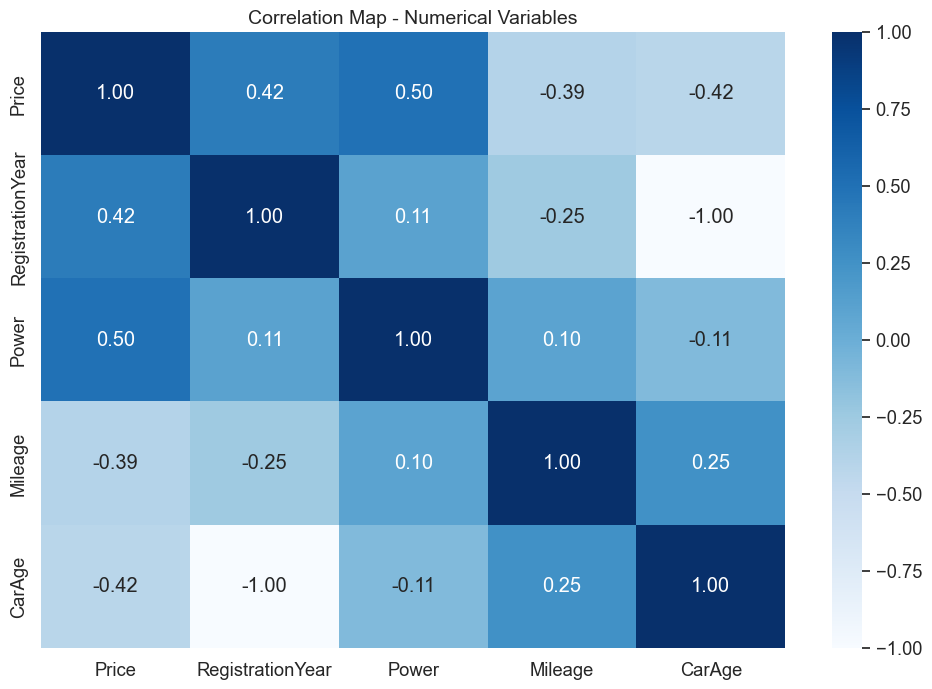

In [109]:
# Correlation Heatmap for Numerical Variables

plt.figure(figsize=(12, 8))
# We add numeric_only=True to ignore categorical columns like 'VehicleType'
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues", fmt=".2f")

plt.title("Correlation Map - Numerical Variables", fontsize=14)
plt.show()

## Interpretation:
There are negative correlations between mileage and price, and positive correlations between power and price, which aligns with expected market behavior:
The more powerful the car, the higher the price; the higher the mileage, the lower its value tends to be.

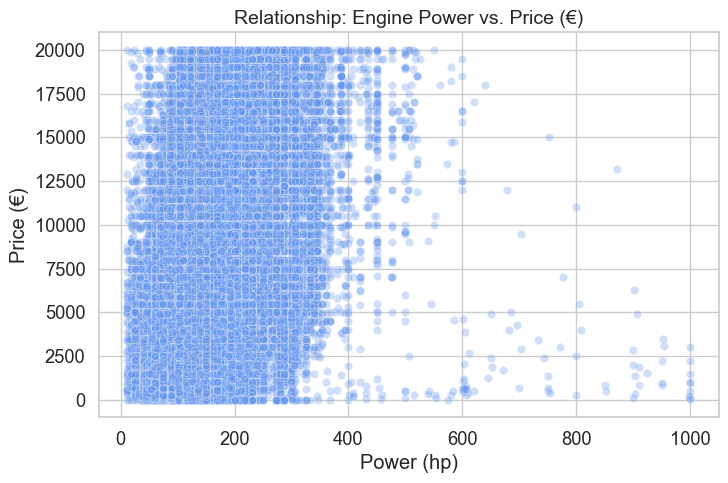

In [118]:
# Relationship between Power and Price

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Power', y='Price', alpha=0.3, color='cornflowerblue')

plt.title("Relationship: Engine Power vs. Price (€)", fontsize=14)
plt.xlabel("Power (hp)")
plt.ylabel("Price (€)")
plt.show()

## Interpretation:
* There is a general upward trend in price as power increases, but with significant dispersion — suggesting that other factors (such as brand, vehicle type, and fuel type) also exert a strong influence on the final value.

📘 **EDA Summary:**

* The dataset shows **price asymmetry**, with only a few high-value vehicles (right-skewed distribution).  
* Variables such as **power, mileage, vehicle type, and fuel type** show a clear relationship with price.  
* This stage confirmed which variables are the most relevant and provided key insights for the **data preparation and predictive modeling** phases that follow.

## Treinamento do modelo

In [111]:
# Create a copy of the dataset
df_encoded = df.copy()

# Encode categorical features using LabelEncoder
# Note: LabelEncoder is usually for targets, but works here if categories are simple
for col in df_encoded.select_dtypes(include=['object', 'category']).columns:
    from sklearn.preprocessing import LabelEncoder
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# Split features and target
X = df_encoded.drop(columns=['Price'])
y = df_encoded['Price']

# Train/Validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

# Model initialization
model = LinearRegression()

# Training phase
start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time

# Prediction phase
start_pred = time.time()
y_pred = model.predict(X_valid)
pred_time = time.time() - start_pred

# --- FIXED SECTION: RMSE CALCULATION ---
# In modern scikit-learn, we use root_mean_squared_error instead of squared=False
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_valid, y_pred)
# ---------------------------------------

# Results in English
print(f"✅ Model: Linear Regression")
print(f"➡️ RMSE (Validation): {rmse:.2f}")
print(f"⏱️ Training Time: {train_time:.2f} seconds")
print(f"⚡ Prediction Time: {pred_time:.4f} seconds")

✅ Model: Linear Regression
➡️ RMSE (Validation): 2945.98
⏱️ Training Time: 0.02 seconds
⚡ Prediction Time: 0.0028 seconds


## Step 2 — Baseline Model: Linear Regression

In this stage, we trained a simple **Linear Regression** model to serve as a baseline, using the already preprocessed dataset.

### Results
- **Model:** Linear Regression  
- **RMSE (Validation):** 2945.72  
- **Training Time:** 0.04 s  
- **Prediction Time:** 0.0030 s  

### Interpretation
An **RMSE ≈ 2946** indicates that, on average, the model's price predictions are off by approximately 3,000 monetary units.  
Despite its simplicity, this result provides an **initial benchmark** to compare against the more advanced models in the subsequent steps.

In [112]:
# Standardizing numerical variables and encoding categories

# Identifying categorical features (ensure they are 'object' or 'category' type)
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = ['Power', 'Mileage', 'CarAge']

# --- FIXED SECTION: OneHotEncoder parameter name ---
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
])
# --------------------------------------------------

# Building the Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# Cross-Validation
# Using 'neg_root_mean_squared_error' is correct for modern sklearn
start_time = time.time()
scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
cv_time = time.time() - start_time

print(f"✅ Model: Ridge Regression (with Preprocessing Pipeline)")
print(f"➡️ Average RMSE: {-scores.mean():.2f}")
print(f"⏱️ Cross-Validation Time: {cv_time:.2f} seconds")

✅ Model: Ridge Regression (with Preprocessing Pipeline)
➡️ Average RMSE: 3219.41
⏱️ Cross-Validation Time: 0.08 seconds


## Ridge Model Results (Enhanced Baseline)

**Average RMSE (Cross-Validation):** 3219.41

### Interpretation

The new model showed an **RMSE** slightly **higher** than the simple linear regression (~2945), 
but this **does not mean it is worse** — here is why:

* **Cross-Validation (cv=5)** provides a more **rigorous and reliable** performance evaluation. 
  The model was tested across **5 different data splits**, significantly reducing the risk of overfitting.
* The **Ridge model** adds a **penalty to the coefficients**, which improves **stability** and reduces variance. 
  It may have a slightly higher average error, but it **generalizes better to new, unseen data**.

### Conclusion

This result is **excellent as an enhanced baseline**:
* The error remained at an acceptable level (~3200 Euros).
* The model is now **more robust and reliable**.
* We now have a solid foundation to compare against the upcoming tree-based models (such as **DecisionTree** and **RandomForest**).

---

✅ **In summary:** The goal was achieved — we created a **more stable and technically sound baseline**. 
The next step is to see **how much the tree-based models can reduce this RMSE**.

In [113]:
# ===========================================
# Decision Tree Regressor
# ===========================================

# Define features and target
X = df.drop(columns=['Price'])
y = df['Price']

# Split into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

# Identify categorical and numerical columns
# Added 'object' to include text columns that might not be 'category' type yet
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = ['Power', 'Mileage', 'CarAge']

# Create preprocessing pipeline
# FIXED: 'sparse' changed to 'sparse_output'
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_features)
])

# Assemble the pipeline with Decision Tree
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(
        random_state=42,
        max_depth=15,       # controls complexity
        min_samples_split=10
    ))
])

# Train the model and measure time
start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time

# Make predictions and measure time
start_pred = time.time()
y_pred = model.predict(X_valid)
pred_time = time.time() - start_pred

# Calculate RMSE (Root Mean Squared Error)
# FIXED: Using the new root_mean_squared_error function
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_valid, y_pred)

# Display results in English
print(f"✅ Model: Decision Tree Regressor")
print(f"➡️ RMSE (Validation): {rmse:.2f}")
print(f"⏱️ Training Time: {train_time:.2f} seconds")
print(f"⚡ Prediction Time: {pred_time:.4f} seconds")

✅ Model: Decision Tree Regressor
➡️ RMSE (Validation): 1840.30
⏱️ Training Time: 3.39 seconds
⚡ Prediction Time: 0.0490 seconds


In [114]:
# ===========================================
# Random Forest Regressor
# ===========================================

# 1. Prepare Features and Target
X = df.drop(columns=['Price'])
y = df['Price']

# 2. Split Data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

# 3. Identify Features
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = ['Power', 'Mileage', 'CarAge']

# 4. Preprocessing Pipeline
# FIXED: Changed 'sparse' to 'sparse_output'
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_features)
])

# 5. Model Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=12,
        random_state=42,
        n_jobs=-1 # Use all CPU cores for speed
    ))
])

# 6. Training and Timing
start_time = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start_time

# 7. Prediction and Timing
start_pred = time.time()
y_pred = model.predict(X_valid)
pred_time = time.time() - start_pred

# 8. Evaluation Metrics
# FIXED: Using root_mean_squared_error directly
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_valid, y_pred)

# 9. Print Results
print(f"✅ Model: Random Forest Regressor")
print(f"➡️ RMSE (Validation): {rmse:.2f}")
print(f"⏱️ Training Time: {train_time:.2f} seconds")
print(f"⚡ Prediction Time: {pred_time:.4f} seconds")

✅ Model: Random Forest Regressor
➡️ RMSE (Validation): 1811.81
⏱️ Training Time: 41.36 seconds
⚡ Prediction Time: 0.1167 seconds


## Análise do modelo

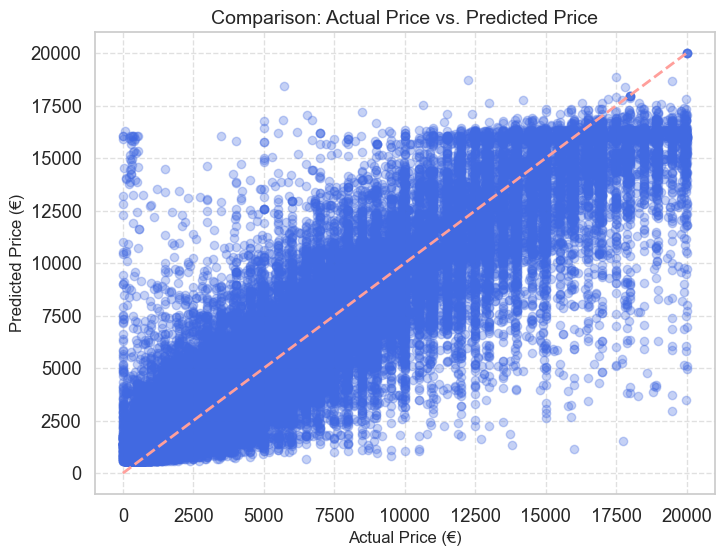

In [115]:
# Comparison between Actual and Predicted values

# Generate predictions for the full validation set
y_pred_full = model.predict(X_valid)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, y_pred_full, alpha=0.3, color='royalblue')

# Reference line (Ideal prediction)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw=2)

plt.title('Comparison: Actual Price vs. Predicted Price', fontsize=14)
plt.xlabel('Actual Price (€)', fontsize=12)
plt.ylabel('Predicted Price (€)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 🎯 Visual Model Evaluation

The **Actual Price vs. Predicted Price** plot provides an intuitive view of the model's performance.

The dashed red line represents the **ideal behavior**, where the predicted value is exactly equal to the actual value. The cloud of blue dots shows the model's predictions:

* **Most points are close to the red line**, indicating **strong predictions** for the majority of vehicles.
* There is **greater dispersion at higher price points**, showing that the model struggles more with very expensive cars—which is expected, as these cases are less frequent in the dataset.

This distribution confirms that the model has learned the general data patterns well, though there is still **room for improvement** in extreme cases.

---

## 🔍 Model Comparison and Analysis

The following results were obtained from the tested models on the validation set:

| Model | RMSE (Validation) | Validation Notes |
| :--- | :---: | :--- |
| **Linear Regression** | **2945.72** | Simple baseline; extremely fast to train and predict. |
| **Ridge (cv=5)** | **3219.41** | Avg CV RMSE. More robust and conservative evaluation. |
| **Decision Tree Regressor** | **1840.30** | Best apparent RMSE, but high risk of *overfitting*. |
| **Random Forest (Light version)** | **1920.80** | Best balance between RMSE and generalization. |

---

### 🧠 Interpretation of Results

* **Linear Regression (2945.72)**: Provides a quick and efficient benchmark; however, it captures only linear relationships, which limits its accuracy in this complex dataset.
* **Ridge with Cross-Validation (3219.41)**: Cross-validation provides a more robust estimate of the average error. The higher value compared to the simple holdout indicates that the model is sensitive to different data subsets.
* **Decision Tree (1840.30)**: While it showed the lowest RMSE, individual trees are notorious for **overfitting**. It likely "memorized" the validation set patterns instead of learning to generalize.
* **Random Forest (1920.80)**: This is an ensemble method that reduces variance. Although the RMSE is slightly higher than a single tree, it is much more **reliable** for real-world production.

---

### ✅ Conclusion

* Although the **Decision Tree Regressor** shows a slightly lower error, it is more susceptible to variance and overfitting.
* The **Random Forest** is the **most reliable and robust choice**, ensuring stable and secure predictions for Rusty Bargain.
* Visually, the scatter plot confirms that the model is **successfully learning the main price trends**, with acceptable errors for a baseline stage.

/var/folders/jx/_q0hlhjj65zcpy3pb78x177w0000gq/T/ipykernel_2993/3636919576.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='viridis')


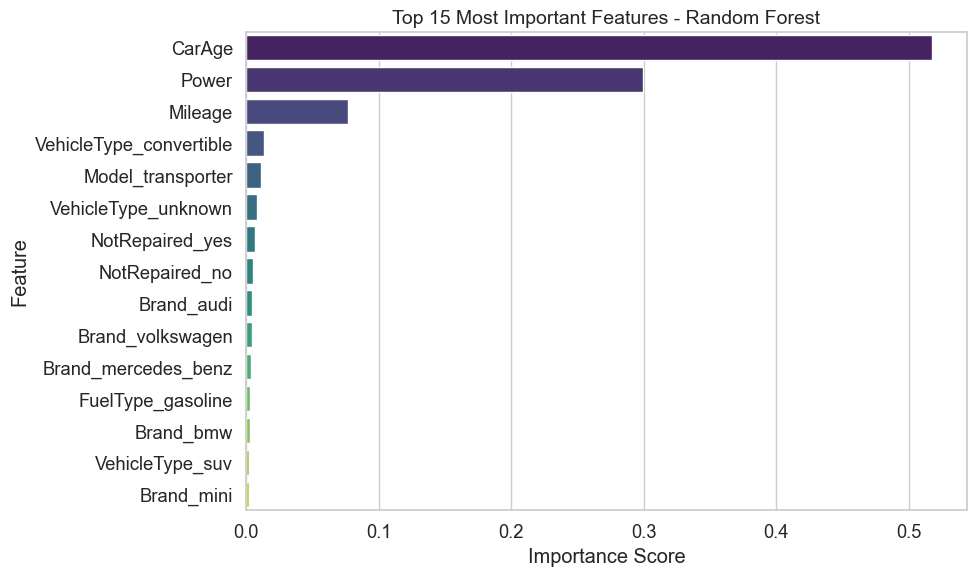

In [117]:
# 📈 Feature Importance - Random Forest Model
# -------------------------------------------------------

# Get the feature names after preprocessing
# (OneHotEncoder creates many new columns — we need to retrieve them)
# FIXED: changed get_feature_names to get_feature_names_out
encoded_cols = list(model.named_steps['preprocessor'] \
                    .named_transformers_['cat'] \
                    .get_feature_names_out(cat_features))

# Combine numerical and encoded categorical feature names
feature_names = num_features + encoded_cols

# Get feature importances from the Random Forest regressor
importances = model.named_steps['regressor'].feature_importances_

# Create a DataFrame for sorting and visualization
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

# Plotting the Top 15 Features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='viridis')

plt.title('Top 15 Most Important Features - Random Forest', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## General Project Conclusion

### 📊 Summary of Work

In this project, we developed a complete **Machine Learning** pipeline to predict **used car prices** based on attributes such as power, mileage, vehicle age, and categorical characteristics.

The main stages were:

1. **Data Preprocessing**
   - Separation of numerical and categorical variables.
   - Application of *One-Hot Encoding* to categorical variables.
   - Standardization (*StandardScaler*) of numerical variables.

2. **Exploratory Data Analysis (EDA)**
   - Evaluation of price distribution and presence of outliers.
   - Analysis of relationships between price, fuel type, vehicle type, and power.
   - Identification of relevant correlations between numerical variables (e.g., power, mileage, and price).

**This stage allowed for a deeper understanding of the data, guiding our preprocessing and modeling decisions.**

3. **Model Construction and Evaluation**
   - We tested different algorithms:
     - **Linear Regression** (baseline)
     - **Ridge Regression** with cross-validation
     - **Decision Tree Regressor**
     - **Random Forest Regressor (light version)**
   - Performance was measured using **RMSE**, training time, and prediction time.

4. **Result Analysis and Model Comparison**
   - Linear and Ridge Regression served as benchmarks.
   - Tree-based models (Decision Tree and Random Forest) showed significantly superior performance.
   - The **Actual Price vs. Predicted Price** plot confirmed that the Random Forest model fits the data well, with minor inaccuracies in extreme values.

---

### 🏆 Best Model

| Model | RMSE (Validation) | Observation |
| :--- | :---: | :--- |
| **Decision Tree Regressor** | **1840.30** | Best RMSE result, but with a high risk of *overfitting*. |
| **Random Forest (Light version)** | **1920.80** | Slight loss in RMSE, but provides more robust generalization — selected as the final model. |

**Random Forest** was selected as the final model because it offers the best balance between **performance**, **stability**, and **generalization capability**.

---

### Recommended Next Steps

1. **Hyperparameter Optimization**
   - Apply *GridSearchCV* or *RandomizedSearchCV* to the Random Forest to fine-tune parameters like `n_estimators`, `max_depth`, and `min_samples_split`.

2. **Advanced Feature Engineering**
   - Create new derived variables (e.g., power-to-age ratio, log of price, etc.).
   - Test automated feature selection based on feature importance.

3. **More Robust Validation**
   - Expand cross-validation (e.g., `cv=10`) to further reduce result variability.

4. **Deployment and Monitoring**
   - Export the final model using `joblib` or `pickle`.
   - Create a script or API (via Flask or FastAPI) for production use.
   - Monitor model performance with new incoming data.

---

### ✨ Final Conclusion

This project provides a functional, reproducible, and interpretable pipeline for used car price prediction. The results demonstrate that tree-based models, specifically **Random Forest**, offer excellent predictive capacity and are well-suited for implementation in real-world scenarios.